# "CDFs with Seaborn"
> Plotting the cumulatlive distribution of latency measurements

- toc: true
- badges: true
- comments: false
- categories: [jupyter, cdf, seabron]

In [1]:
#hide
from collections import Counter
import pandas as pd
import seaborn as sns
import random as r

r.seed(42)
sns.set()

In [2]:
#hide
# generate the dataset
data = []

for path in ['a', 'b', 'c']:
  for timestamp in range(1, 10001):
    latency = -1
    if (path == 'a'):
      latency = r.normalvariate(30, 3)
    elif (path == 'b'):
      latency = r.normalvariate(40, 10)
    else:
      # c has a 50/50 latency
      if (r.choice([True, False])):
        latency = r.normalvariate(40, 1)
      else:
        latency = r.normalvariate(60, 1)

    data.append({
      'timestamp': timestamp,
      'path': path,
      'latency': latency
    })

df = pd.DataFrame(data)

df[df.path == 'a'].describe(), df[df.path == 'b'].describe(), df[df.path == 'c'].describe()

(         timestamp       latency
 count  10000.00000  10000.000000
 mean    5000.50000     29.992668
 std     2886.89568      3.045471
 min        1.00000     18.794713
 25%     2500.75000     27.926180
 50%     5000.50000     29.967227
 75%     7500.25000     32.047904
 max    10000.00000     41.444034,
          timestamp       latency
 count  10000.00000  10000.000000
 mean    5000.50000     40.047845
 std     2886.89568      9.940275
 min        1.00000      1.230942
 25%     2500.75000     33.460950
 50%     5000.50000     40.048686
 75%     7500.25000     46.730936
 max    10000.00000     71.753491,
          timestamp       latency
 count  10000.00000  10000.000000
 mean    5000.50000     49.982874
 std     2886.89568     10.060132
 min        1.00000     36.721305
 25%     2500.75000     39.991170
 50%     5000.50000     42.958066
 75%     7500.25000     59.988394
 max    10000.00000     63.566645)

# Introduction

During my PHD, I often had to create CDF (cumulative distribution function) plots.
For example, I use CDF plots in my paper *Managing Latency and Excess Data Dissemination in Fog-Based Publish/Subscribe Systems* ([DOI](https://doi.org/10.1109/ICFC49376.2020.00010)/[Website](https://moewex.github.io/academic/publication/2020-broadcastgroups/)) for reporting latency measurement that have been collected by multiple end-devices for different data distribution strategies.

In this blog post, I will showcase why CDFs are a particulary good fit for such a use case and how easy it is to generate them with [seaborn](https://seaborn.pydata.org).

# Exploring the Sample Data

For the purpose of this blog post, I created an artificial sample dataset with latency measurements for three coummunication paths.

In [3]:
df.head()

,timestamp,path,latency
0,1,a,30.735979
1,2,a,28.509467
2,3,a,33.764358
3,4,a,29.585823
4,5,a,27.072539


<AxesSubplot:xlabel='path', ylabel='latency'>

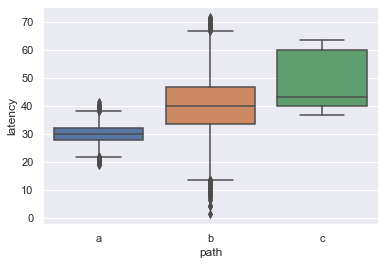

In [4]:
sns.boxplot(data=df, x='path', y='latency')

Plotting the data in a boxplot already tells us that the communication path a experiences the smallest median latency.
Communication path b has a slightly lower median latency then c, but larger min and max values.

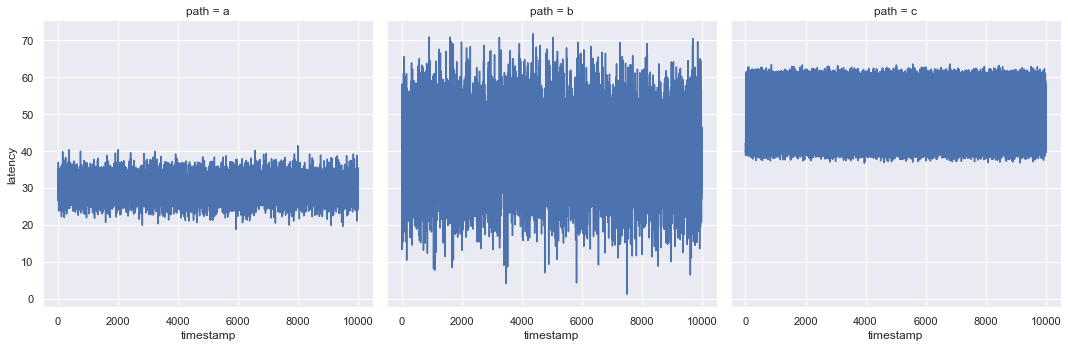

In [5]:
sns.relplot(data=df, kind='line', x='timestamp', y='latency', col='path')

Plotting the latencies as line plots tells us that the latency pattern does not change throughout the experiment.

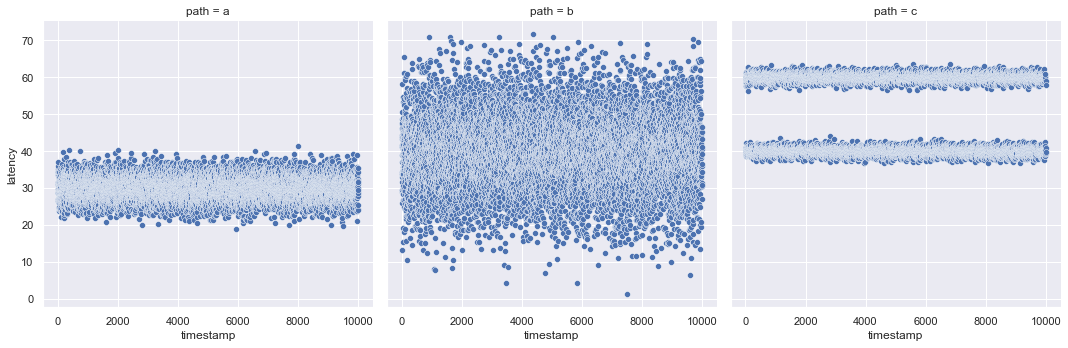

In [6]:
sns.relplot(data=df, kind='scatter', x='timestamp', y='latency', col='path')

The scatter plot reveals something very interesting:
There are two groups of measurements on communication path c: one with a latency of about 60, and one with a latency of about 40.
This information is not available from the box or line plot.

# Calculating the Cumulatative Distribution

For a reasearch paper, you typically only want as few plots as possible since you only have limited space available.
Thus, a CDF plot is often a good option since it a high information densitiy.
The first step for creating such a plot is to calculate the cumulative distribution of your input data.
In our case, we want to plot the cumulative distribution of latency measurements for each path. 

In [7]:
# Calculate cumulative distribution for each path
df_cdf = pd.DataFrame()
paths = df['path'].unique()

for path in paths:
      # create dataframe for each path
      path_df = df[(df['path'] == path)]

      # create dataframe with count per latency for the chosen path
      df_tmp = pd.DataFrame(dict(Counter(path_df['latency'])), index=[0]).T
      # transform index into column
      df_tmp.reset_index(inplace=True)
      # set correct column names
      df_tmp.columns = ['latency', 'count']
      # add a path column
      df_tmp.insert(0, 'path', path)

      # calculate distribution
      df_tmp.sort_values(by='latency', inplace=True)
      df_tmp["cumsum"] = df_tmp["count"].cumsum()
      sum = df_tmp["count"].sum()
      df_tmp["cumulative_distribution"] = df_tmp["cumsum"] / sum

      # add to result df
      df_cdf = df_cdf.append(df_tmp)
    
# sort and reset the index just for the asthetics
df_cdf.reset_index(inplace=True, drop=True)
df_cdf.sort_values(by="path", inplace=True)

# let's check how it looks
df_cdf

,path,latency,count,cumsum,cumulative_distribution
0,a,18.794713,1,1,0.0001
6663,a,31.286361,1,6664,0.6664
6664,a,31.286763,1,6665,0.6665
6665,a,31.286795,1,6666,0.6666
6666,a,31.286961,1,6667,0.6667
...,...,...,...,...,...
23333,c,40.414325,1,3334,0.3334
23334,c,40.414616,1,3335,0.3335
23335,c,40.414784,1,3336,0.3336
23328,c,40.411314,1,3329,0.3329


As you can see, the resulting dataframe contains information on how often each latency occurs for each path, as well as corresponding cumulative distribution.
Plotting this data is then straight forward.

<AxesSubplot:xlabel='latency', ylabel='cumulative_distribution'>

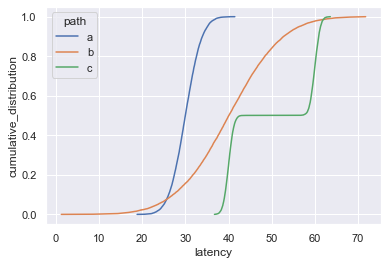

In [8]:
sns.lineplot(data=df_cdf, x="latency", y="cumulative_distribution", hue="path")

This plot tells us quite a lot. By looking at the cumulative distribution, we can easily retrieve the min (0.0) and max (1.0) latency, as well as latency ranges. 
E.g., to for path a, 60% of all measurements are betwwen 27 and 33.
Furthermore, we can retrieve information on the distribution of values, e.g., b has a higher variance then a.
We can also identify distinct groups of measurements by looking for *steps* in the distribution function as for path c.
In this case, we can confirm that there are two groups, but also learn that each group has the same size, i.e., each group contains 50% of the measurements.

If your data has more dimensions, e.g., there could also be a client column that indicates which client sent a request, you only need to make minor modifications.
To not collapse all dimensions into the *path-lines*, you have to add one nested for-loop for each additional dimension.
This could then look like so:

```python
paths = df['path'].unique()

for path in paths:
  for client in paths['client'].unique():
      # create dataframe for each path and client
      path_client_df = df[(df['path'] == path) & (df['client'] == client)]

      # continue as normal, but do not forget to also add a client column

# Closing Remarks

In this blog post, I quickly showcased how one can create CDF plots with seaborn, and why they are a particularly good fit for latency measurements.
The presented approach can also be applied to datasets with more dimensions by adding nested for-loops.